<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow2/Tutorial/Customising_TensorFlow2_models/Neural_translation/Neural_translation_English_German.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project
## Neural translation model
### Instructions

In this notebook, you will create a neural network that translates from English to German. You will use concepts from throughout this course, including building more flexible model architectures, freezing layers, data processing pipeline and sequence modelling.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Input, Masking, LSTM, \
    Embedding, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Mean

![Flags overview image](https://github.com/MengOonLee/Deep_learning/blob/master/TensorFlow2/Tutorial/image/neural_translation/germany_uk_flags.png?raw=1)

For the capstone project, you will use a language dataset from http://www.manythings.org/anki/ to build a neural translation model. This dataset consists of over 200,000 pairs of sentences in English and German. In order to make the training quicker, we will restrict to our dataset to 20,000 pairs. Feel free to change this if you wish - the size of the dataset used is not part of the grading rubric.

Your goal is to develop a neural translation model from English to German, making use of a pre-trained English word embedding module.

#### Import the data

The dataset is available for download as a zip file at the following link:

https://drive.google.com/open?id=1KczOciG7sYY7SB9UlBeRP1T9659b121Q

You should store the unzipped folder in local drive for use in this Colab notebook.

In [2]:
if not os.path.exists("./data"):
    os.makedirs("./data")

In [3]:
%%bash

fileid="1KczOciG7sYY7SB9UlBeRP1T9659b121Q"
filename="./data/deu.txt"
curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=${fileid}" > /dev/null
curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=${fileid}" -o ${filename}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0    333      0 --:--:--  0:00:01 --:--:--   333
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 29.9M    0 29.9M    0     0  16.9M      0 --:--:--  0:00:01 --:--:-- 16.9M


In [4]:
# Run this cell to load the dataset

NUM_EXAMPLES = 20000
data_examples = []
with open('data/deu.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

In [5]:
# These functions preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) 
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)
    
    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence.strip()

#### The custom translation model
The following is a schematic of the custom translation model architecture you will develop in this project.

![Model Schematic](https://github.com/MengOonLee/Deep_learning/blob/master/TensorFlow2/Tutorial/image/neural_translation/neural_translation_model.png?raw=1)

Key:
![Model key](https://github.com/MengOonLee/Deep_learning/blob/master/TensorFlow2/Tutorial/image/neural_translation/neural_translation_model_key.png?raw=1)

The custom model consists of an encoder RNN and a decoder RNN. The encoder takes words of an English sentence as input, and uses a pre-trained word embedding to embed the words into a 128-dimensional space. To indicate the end of the input sentence, a special end token (in the same 128-dimensional space) is passed in as an input. This token is a TensorFlow Variable that is learned in the training phase (unlike the pre-trained word embedding, which is frozen).

The decoder RNN takes the internal state of the encoder network as its initial state. A `<start>` token is passed in as the first input, which is embedded using a learned German word embedding. The decoder RNN then makes a prediction for the next German word, which during inference is then passed in as the following input, and this process is repeated until the special `<end>` token is emitted from the decoder.

## 1. Text preprocessing
* Create separate lists of English and German sentences, and preprocess them using the `preprocess_sentence` function provided for you above.
* Add a special `"<start>"` and `"<end>"` token to the beginning and end of every German sentence.
* Use the Tokenizer class from the `tf.keras.preprocessing.text` module to tokenize the German sentences, ensuring that no character filters are applied. _Hint: use the Tokenizer's "filter" keyword argument._
* Print out at least 5 randomly chosen examples of (preprocessed) English and German sentence pairs. For the German sentence, print out the text (with start and end tokens) as well as the tokenized sequence.
* Pad the end of the tokenized German sequences with zeros, and batch the complete set of sequences into one numpy array.

In [6]:
def create_sentence(data):
    """
    Clean the input and return sentence pairs.
    """
    sentence_pairs = [[preprocess_sentence(w) for w in l.split('\t')][:2] 
        for l in data]
    return zip(*sentence_pairs)

# get pairs
en_sentence, ge_sentence = create_sentence(data_examples)
# show last 5 pairs
for pair in zip(en_sentence[-5:], ge_sentence[-5:]):
    print(pair)

("i've been working .", 'ich war arbeiten .')
("i've bought a car .", 'ich habe ein auto gekauft .')
("i've come for tom .", 'ich bin fuer tom gekommen .')
("i've done nothing .", 'ich habe nichts getan .')
("i've eaten enough .", 'ich habe genug gegessen .')


In [7]:
def add_start_end(sentences):
    """
    Adding a start and end token to the sentence so that the
    model know when to start and stop predicting.
    """
    return ["<start> " + s + " <end>" for s in sentences]

ge_sentence = add_start_end(ge_sentence)
ge_sentence[-5:]

['<start> ich war arbeiten . <end>',
 '<start> ich habe ein auto gekauft . <end>',
 '<start> ich bin fuer tom gekommen . <end>',
 '<start> ich habe nichts getan . <end>',
 '<start> ich habe genug gegessen . <end>']

In [8]:
def create_tokenizer(sentences):
    """
    Create and return a Tokenizer.
    """
    tokenizer = Tokenizer(filters='')
    tokenizer.fit_on_texts(sentences)
    return tokenizer

# Build the German tokenizer vocabulary
ge_tokenizer = create_tokenizer(ge_sentence)
# Tokenize the German sentences
ge_sequence = ge_tokenizer.texts_to_sequences(ge_sentence)
ge_sequence[-5:]

[[1, 4, 24, 252, 3, 2],
 [1, 4, 18, 19, 82, 280, 3, 2],
 [1, 4, 15, 77, 5, 276, 3, 2],
 [1, 4, 18, 108, 182, 3, 2],
 [1, 4, 18, 480, 217, 3, 2]]

In [9]:
# Randomly select 5 examples of English and German sentence pairs
inx = np.random.choice(len(en_sentence), 5, replace=False)

for n, i in enumerate(inx):
    print(n, en_sentence[i])
    print(n, ge_sentence[i], ge_sequence[i])

0 i love cake .
0 <start> ich liebe kuchen . <end> [1, 4, 61, 828, 3, 2]
1 i'm really fast .
1 <start> ich bin sehr schnell . <end> [1, 4, 15, 56, 127, 3, 2]
2 i'm not guilty .
2 <start> ich bin nicht schuldig . <end> [1, 4, 15, 12, 564, 3, 2]
3 keep paddling .
3 <start> paddel weiter ! <end> [1, 3650, 126, 9, 2]
4 do what you like .
4 <start> tu , was dir beliebt . <end> [1, 266, 25, 38, 52, 831, 3, 2]


In [10]:
def post_pad(sequences):
    """
    Pad each sequence to a maximum length.
    """
    return pad_sequences(sequences, padding='post')

ge_padded = post_pad(ge_sequence)
ge_padded[-5:]

array([[  1,   4,  24, 252,   3,   2,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  1,   4,  18,  19,  82, 280,   3,   2,   0,   0,   0,   0,   0,
          0],
       [  1,   4,  15,  77,   5, 276,   3,   2,   0,   0,   0,   0,   0,
          0],
       [  1,   4,  18, 108, 182,   3,   2,   0,   0,   0,   0,   0,   0,
          0],
       [  1,   4,  18, 480, 217,   3,   2,   0,   0,   0,   0,   0,   0,
          0]], dtype=int32)

## 2. Prepare the data with tf.data.Dataset objects

#### Load the embedding layer
As part of the dataset preproceessing for this project, you will use a pre-trained English word embedding module from TensorFlow Hub. The URL for the module is https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1.

This embedding takes a batch of text tokens in a 1-D tensor of strings as input. It then embeds the separate tokens into a 128-dimensional space. 

The code to load and test the embedding layer is provided for you below.

**NB:** This model can also be used as a sentence embedding module. The module will process each token by removing punctuation and splitting on spaces. It then averages the word embeddings over a sentence to give a single embedding vector. However, we will use it only as a word embedding module, and will pass each word in the input sentence as a separate token.

In [11]:
# Load embedding module from Tensorflow Hub
embedding_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", 
    output_shape=(128), input_shape=(), dtype=tf.string)

In [12]:
# Test the layer

embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape

TensorShape([7, 128])

You should now prepare the training and validation Datasets.

* Create a random training and validation set split of the data, reserving e.g. 20% of the data for validation (NB: each English dataset example is a single sentence string, and each German dataset example is a sequence of padded integer tokens).
* Load the training and validation sets into a tf.data.Dataset object, passing in a tuple of English and German data for both training and validation sets.
* Create a function to map over the datasets that splits each English sentence at spaces. Apply this function to both Dataset objects using the map method. _Hint: look at the tf.strings.split function._
* Create a function to map over the datasets that embeds each sequence of English words using the loaded embedding layer/model. Apply this function to both Dataset objects using the map method.
* Create a function to filter out dataset examples where the English sentence is greater than or equal to than 13 (embedded) tokens in length. Apply this function to both Dataset objects using the filter method.
* Create a function to map over the datasets that pads each English sequence of embeddings with some distinct padding value before the sequence, so that each sequence is length 13. Apply this function to both Dataset objects using the map method. _Hint: look at the tf.pad function. You can extract a Tensor shape using tf.shape; you might also find the tf.math.maximum function useful._
* Batch both training and validation Datasets with a batch size of 16.
* Print the `element_spec` property for the training and validation Datasets. 
* Using the Dataset `.take(1)` method, print the shape of the English data example from the training Dataset.
* Using the Dataset `.take(1)` method, print the German data example Tensor from the validation Dataset.

In [13]:
# Create a random training and validation sets using an 80-20 split
en_train, en_valid, ge_train, ge_valid = train_test_split(
    en_sentence, ge_padded, test_size=0.2)

# Examine the shape of data
print("The shape of training dataset:")
print(f"English: {np.array(en_train).shape} \t German: {ge_train.shape}")
print("The shape of validation dataset:")
print(f"English: {np.array(en_valid).shape} \t German: {ge_valid.shape}")


The shape of training dataset:
English: (16000,) 	 German: (16000, 14)
The shape of validation dataset:
English: (4000,) 	 German: (4000, 14)


In [14]:
def create_dataset(input, target):
    """
    Takes an input language, and a corresponding target language 
    to create a tf.data.Dataset object with these input and target.
    """
    return tf.data.Dataset.from_tensor_slices((input, target))

# Create Dataset object for both training and vailidation sets
train_dataset = create_dataset(en_train, ge_train)
valid_dataset = create_dataset(en_valid, ge_valid)

# # Print the first 5 elements of the Dataset
for elem in iter(train_dataset.take(5)):
    print(elem[0].numpy(), elem[1].numpy())

b'read the article .' [   1  677   53 3076    9    2    0    0    0    0    0    0    0    0]
b"i'm doing ok ." [   1   21   59   10 3429   49    3    2    0    0    0    0    0    0]
b"they're crazy ." [  1  26  35   8  12 144  78   9   2   0   0   0   0   0]
b'black suits you .' [  1 505 287  52  49   3   2   0   0   0   0   0   0   0]
b"you're not alone ." [  1  13  32  12 524   3   2   0   0   0   0   0   0   0]


In [15]:
def map_split(x, _):
    """
    Splits each English sentence at spaces.
    """
    return (tf.strings.split(x, sep=' '), _)

# Map the function over the both Dataset objects. 
train_dataset = train_dataset.map(map_split)
valid_dataset = valid_dataset.map(map_split)

# # Print the first 5 elements of the Dataset
for elem in iter(train_dataset.take(5)):
    print(elem[0].numpy(), elem[1].numpy())

[b'read' b'the' b'article' b'.'] [   1  677   53 3076    9    2    0    0    0    0    0    0    0    0]
[b"i'm" b'doing' b'ok' b'.'] [   1   21   59   10 3429   49    3    2    0    0    0    0    0    0]
[b"they're" b'crazy' b'.'] [  1  26  35   8  12 144  78   9   2   0   0   0   0   0]
[b'black' b'suits' b'you' b'.'] [  1 505 287  52  49   3   2   0   0   0   0   0   0   0]
[b"you're" b'not' b'alone' b'.'] [  1  13  32  12 524   3   2   0   0   0   0   0   0   0]


In [16]:
def map_embed(x, _):
    """
    Embeds each sequence of English words using the loaded embedding layer.
    """
    return (embedding_layer(x), _)

# Map the function over the both Dataset objects. 
train_dataset = train_dataset.map(map_embed)
valid_dataset = valid_dataset.map(map_embed)

# Print the element_spec property for both Datasets
print("The training Dataset's element_spec property:")
print(train_dataset.element_spec)
print("The validation Dataset's element_spec property:")
print(valid_dataset.element_spec)

The training Dataset's element_spec property:
(TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(14,), dtype=tf.int32, name=None))
The validation Dataset's element_spec property:
(TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(14,), dtype=tf.int32, name=None))


In [17]:
def filter_length(x, _):
    """
    Filter out dataset examples where the English sentence is 
    greater than or equal to 13 (embedded) tokens in length.
    """
    return len(x)<13

# Filter over the both Dataset objects.
train_dataset = train_dataset.filter(filter_length)
valid_dataset = valid_dataset.filter(filter_length)

# Print the element_spec property for both Datasets
print("The training Dataset's element_spec property:")
print(train_dataset.element_spec)
print("The validation Dataset's element_spec property:")
print(valid_dataset.element_spec)

The training Dataset's element_spec property:
(TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(14,), dtype=tf.int32, name=None))
The validation Dataset's element_spec property:
(TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(14,), dtype=tf.int32, name=None))


In [18]:
def map_pad_embedding(x, _):
    """
    Pads each English sequence of embeddings with some distinct
    padding value before the sequence, so that each sequence is
    length 13.
    """
    pad_size = tf.math.maximum(0, 13 - tf.shape(x)[0])
    paddings = tf.concat(([[pad_size, 0]], [[0, 0]]), axis=0)
    padded = tf.pad(x, paddings, "CONSTANT")
    return (tf.reshape(padded, (13, 128)), _)

# Map the function over the both Dataset objects. 
train_dataset = train_dataset.map(map_pad_embedding)
valid_dataset = valid_dataset.map(map_pad_embedding)

# Print the element_spec property for both Datasets
print("The training Dataset's element_spec property:")
print(train_dataset.element_spec)
print("The validation Dataset's element_spec property:")
print(valid_dataset.element_spec)

The training Dataset's element_spec property:
(TensorSpec(shape=(13, 128), dtype=tf.float32, name=None), TensorSpec(shape=(14,), dtype=tf.int32, name=None))
The validation Dataset's element_spec property:
(TensorSpec(shape=(13, 128), dtype=tf.float32, name=None), TensorSpec(shape=(14,), dtype=tf.int32, name=None))


In [19]:
def create_batch(dataset, batch_size):
  """
  Batch the dataset using the batch_size argument, 
  setting drop_remainder to True.
  """
  return dataset.batch(batch_size, drop_remainder=True)

# Batch the both Datasets with a batch size of 16.
train_dataset = create_batch(train_dataset, 16)
valid_dataset = create_batch(valid_dataset, 16)

# Print the element_spec property for both Datasets
print("The training Dataset's element_spec property:")
print(train_dataset.element_spec)
print("The validation Dataset's element_spec property:")
print(valid_dataset.element_spec)

The training Dataset's element_spec property:
(TensorSpec(shape=(16, 13, 128), dtype=tf.float32, name=None), TensorSpec(shape=(16, 14), dtype=tf.int32, name=None))
The validation Dataset's element_spec property:
(TensorSpec(shape=(16, 13, 128), dtype=tf.float32, name=None), TensorSpec(shape=(16, 14), dtype=tf.int32, name=None))


In [20]:
# Print the shape of the English data example from the training Dataset
en_train_batch, _ = next(iter(train_dataset.take(1)))
print("The shape of English data example from the training Dataset:", 
    en_train_batch.shape)

# Print the German data example Tensor from the validation Dataset
_, ge_valid_batch = next(iter(valid_dataset.take(1)))
print("The German data example Tensor from the validation Dataset:\n", 
    ge_valid_batch.numpy())

The shape of English data example from the training Dataset: (16, 13, 128)
The German data example Tensor from the validation Dataset:
 [[   1    4  213   22   56 2575    3    2    0    0    0    0    0    0]
 [   1   30    8  112   92    7    2    0    0    0    0    0    0    0]
 [   1  673  334  780    9    2    0    0    0    0    0    0    0    0]
 [   1  134    4   21   11 5431    7    2    0    0    0    0    0    0]
 [   1    5  241  125    3    2    0    0    0    0    0    0    0    0]
 [   1    5   16 2084    3    2    0    0    0    0    0    0    0    0]
 [   1    5   16   34 4499    3    2    0    0    0    0    0    0    0]
 [   1    5   48  108  698   35    3    2    0    0    0    0    0    0]
 [   1    5 1824   65  814    3    2    0    0    0    0    0    0    0]
 [   1    5  308   65    3    2    0    0    0    0    0    0    0    0]
 [   1    8 3090   22    3    2    0    0    0    0    0    0    0    0]
 [   1 5460    7    2    0    0    0    0    0    0    0    0

## 3. Create the custom layer
You will now create a custom layer to add the learned end token embedding to the encoder model:

![Encoder schematic](https://github.com/MengOonLee/Deep_learning/blob/master/TensorFlow2/Tutorial/image/neural_translation/neural_translation_model_encoder.png?raw=1)

You should now build the custom layer.
* Using layer subclassing, create a custom layer that takes a batch of English data examples from one of the Datasets, and adds a learned embedded ‘end’ token to the end of each sequence. 
* This layer should create a TensorFlow Variable (that will be learned during training) that is 128-dimensional (the size of the embedding space). _Hint: you may find it helpful in the call method to use the tf.tile function to replicate the end token embedding across every element in the batch._
* Using the Dataset `.take(1)` method, extract a batch of English data examples from the training Dataset and print the shape. Test the custom layer by calling the layer on the English data batch Tensor and print the resulting Tensor shape (the layer should increase the sequence length by one).

In [46]:
# Create a custom layer to add a learned end token embedding 
# to the encoder model using Layer subclassing API 
# according to the above specification.

class EndToken(Layer):
    """
    Takes a batch of English data examples from Datasets, and adds 
    a learned embedded 'end' token to the end of each sequence.
    """
    def __init__(self, **kwargs):
        super(EndToken, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.end_var = self.add_weight(shape=(input_shape[-1],), 
            initializer="random_normal", name="end")
        # self.end_token = tf.tile(self.end_var, (input_shape[0], 1))

    def call(self, inputs):
        return self.end_var
        # return tf.concat([inputs, self.end_token], axis=1)

# Instantiate the custom layer object
end_token = EndToken()
end_token(en_train_batch)
end_token.trainable_variables

[<tf.Variable 'end_token_9/end:0' shape=(128,) dtype=float32, numpy=
 array([-4.22076173e-02,  2.62377802e-02, -2.49393079e-02, -5.87892942e-02,
         4.06863913e-03,  6.80565462e-02, -1.32284939e-01, -6.91651776e-02,
         1.00331707e-02, -5.53480946e-02,  1.75081994e-02,  5.31358086e-02,
        -8.71938616e-02,  9.59187374e-03, -9.95273888e-02,  4.49895635e-02,
         3.85218523e-02, -1.28584644e-02,  3.59058492e-02, -3.58383022e-02,
        -5.62324002e-03,  6.71292767e-02,  1.00955777e-01, -9.73976031e-03,
         1.64765790e-02,  5.14289029e-02,  6.91589341e-02, -5.68033941e-02,
         2.17283261e-03, -5.25258295e-02,  2.23529171e-02, -2.36906111e-02,
        -6.72826618e-02,  9.25394222e-02,  5.58651388e-02,  8.00540950e-03,
         5.69629557e-02,  8.79428983e-02,  1.25540188e-02,  1.68147087e-02,
        -7.35148266e-02,  3.30088213e-02, -3.78754847e-02, -7.99248070e-02,
         4.02071849e-02, -8.28499570e-02, -1.11380359e-02,  4.60318588e-02,
        -2.86451820

In [22]:
# Extract a batch of English data examples from the training Dataset.
en_train_batch, _ = next(iter(train_dataset.take(1)))
# Print the shape before the custom layer
print("English data batch Tensor shape before the custom end_token layer:", 
    en_train_batch.shape)

English data batch Tensor shape before the custom end_token layer: (16, 13, 128)


In [37]:
# Test the custom layer on the English data batch Tensor 
# and print the resulting Tensor shape
print("English data batch Tensor shape after the custom end_token layer:", 
    end_token(en_train_batch).shape)

# Print the number of trainable variables
print('Number of trainable variables in the end_token layer:', 
    len(end_token.trainable_variables))

ValueError: ignored

## 4. Build the encoder network
The encoder network follows the schematic diagram above. You should now build the RNN encoder model.
* Using the functional API, build the encoder network according to the following spec:
    * The model will take a batch of sequences of embedded English words as input, as given by the Dataset objects.
    * The next layer in the encoder will be the custom layer you created previously, to add a learned end token embedding to the end of the English sequence.
    * This is followed by a Masking layer, with the `mask_value` set to the distinct padding value you used when you padded the English sequences with the Dataset preprocessing above.
    * The final layer is an LSTM layer with 512 units, which also returns the hidden and cell states.
    * The encoder is a multi-output model. There should be two output Tensors of this model: the hidden state and cell states of the LSTM layer. The output of the LSTM layer is unused.
* Using the Dataset `.take(1)` method, extract a batch of English data examples from the training Dataset and test the encoder model by calling it on the English data Tensor, and print the shape of the resulting Tensor outputs.
* Print the model summary for the encoder network.

In [24]:
# Build a RNN encoder model using the functional API
# according to the above specification.

# A batch of sequences of embedded English words from Dataset object as input.
inputs = Input(batch_shape=train_dataset.element_spec[0].shape)
# Add a learned end token embedding to the end of 
# the English sequence using the end_token layer.
h = end_token(inputs)
# A Masking layer with the mask_value=0.0.
h = Masking(mask_value=0.0)(h)
# A LSTM layer with 512 units returns the hidden and cell states.
_, hidden, cell = LSTM(units=512, return_state=True)(h)

# Create the RNN encoder model object
encoder = Model(inputs=inputs, outputs=[hidden, cell])

In [25]:
# Extract a batch of English data examples from the training Dataset.
en_train_batch, _ = next(iter(train_dataset.take(1)))

# Test the encoder model on the English data tensor, 
# and print the shape of the resulting Tensor outputs.
enc_hidden, enc_cell = encoder(en_train_batch)
print("The shape of Encoder hidden state output: (batch_size, units)", 
    enc_hidden.shape)
print("The shape of Encoder cell state output: (batch_size, units)", 
    enc_cell.shape)

# Print the number of trainable variables
print('Number of trainable variables in the RNN encoder_model:', 
    len(encoder.trainable_variables))

The shape of Encoder hidden state output: (batch_size, units) (16, 512)
The shape of Encoder cell state output: (batch_size, units) (16, 512)
Number of trainable variables in the RNN encoder_model: 4


In [26]:
# Print the model summary for the encoder network
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(16, 13, 128)]           0         
_________________________________________________________________
end_token (EndToken)         (16, 14, 128)             128       
_________________________________________________________________
masking (Masking)            (16, 14, 128)             0         
_________________________________________________________________
lstm (LSTM)                  [(16, 512), (16, 512), (1 1312768   
Total params: 1,312,896
Trainable params: 1,312,896
Non-trainable params: 0
_________________________________________________________________


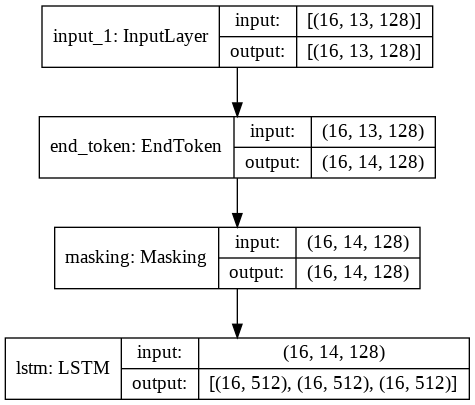

In [27]:
# Plot the Encoder RNN model
plot_model(encoder, 'encoder.png', show_shapes=True)

## 5. Build the decoder network
The decoder network follows the schematic diagram below.

![Decoder schematic](https://github.com/MengOonLee/Deep_learning/blob/master/TensorFlow2/Tutorial/image/neural_translation/neural_translation_model_decoder.png?raw=1)

You should now build the RNN decoder model.
* Using Model subclassing, build the decoder network according to the following spec:
    * The initializer should create the following layers:
        * An Embedding layer with vocabulary size set to the number of unique German tokens, embedding dimension 128, and set to mask zero values in the input.
        * An LSTM layer with 512 units, that returns its hidden and cell states, and also returns sequences.
        * A Dense layer with number of units equal to the number of unique German tokens, and no activation function.
    * The call method should include the usual `inputs` argument, as well as the additional keyword arguments `hidden_state` and `cell_state`. The default value for these keyword arguments should be `None`.
    * The call method should pass the inputs through the Embedding layer, and then through the LSTM layer. If the `hidden_state` and `cell_state` arguments are provided, these should be used for the initial state of the LSTM layer. _Hint: use the_ `initial_state` _keyword argument when calling the LSTM layer on its input._
    * The call method should pass the LSTM output sequence through the Dense layer, and return the resulting Tensor, along with the hidden and cell states of the LSTM layer.
* Using the Dataset `.take(1)` method, extract a batch of English and German data examples from the training Dataset. Test the decoder model by first calling the encoder model on the English data Tensor to get the hidden and cell states, and then call the decoder model on the German data Tensor and hidden and cell states, and print the shape of the resulting decoder Tensor outputs.
* Print the model summary for the decoder network.

In [28]:
# Build an RNN decoder model using Model subclassing API
# according to the above specification.

class Decoder(Model):
    """
    Takes a batch of German data Tensor from the Dataset through an 
    Embedding layer with vocab_size set to number of unique German 
    token. It is followed by an LSTM layer with initial state are 
    provided by the hidden and cell states from the RNN encoder model on 
    the English data Tensor. The LSTM output sequence is passed through 
    the final Dense layer, which returns the resulting Tensor, along with 
    the hidden and cell states of the LSTM layer.
    """
    def __init__(self, vocab_size, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        # Define layers
        self.embedding = Embedding(input_dim=vocab_size, 
            output_dim=128, mask_zero=True)
        self.lstm = LSTM(units=512, return_state=True, 
            return_sequences=True)
        self.dense = Dense(units=vocab_size, activation=None)

    def call(self, inputs, states=None):
        # Define forward pass
        h = self.embedding(inputs)
        if states is None:
            states = self.lstm.get_initial_state(x)
        h, _, _ = self.lstm(h, initial_state=states)
        outputs = self.dense(h)
        return outputs

# Vocabulary size set to the number of unique German tokens
vocab_size = len(ge_tokenizer.word_index) + 1
# Instantiate the RNN decoder model object
decoder = Decoder(vocab_size=vocab_size)

In [29]:
# Extract a batch of English and German data examples 
# from the training Dataset
en_train_batch, ge_train_batch = next(iter(train_dataset.take(1)))

# First call the encoder model on the English data Tensor
# to get the hidden and cell states
enc_hidden, enc_cell = encoder(en_train_batch)

# Then test the decoder model on the German data Tensor,
# the hidden and cell states from the encoder model, 
# and print the shape of the resulting decoder Tensor outputs.
dec_outputs = decoder(ge_train_batch, 
    states=[enc_hidden, enc_cell])
print("The shape of Decoder outputs: (batch_size, sequence_length, units)", 
    dec_outputs.shape)

# Print the number of trainable variables
print('Number of trainable variables in the RNN decoder_model:', 
    len(decoder.trainable_variables))

The shape of Decoder outputs: (batch_size, sequence_length, units) (16, 14, 5744)
Number of trainable variables in the RNN decoder_model: 6


In [30]:
# Print the model summary for the decoder network.
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  735232    
_________________________________________________________________
lstm_1 (LSTM)                multiple                  1312768   
_________________________________________________________________
dense (Dense)                multiple                  2946672   
Total params: 4,994,672
Trainable params: 4,994,672
Non-trainable params: 0
_________________________________________________________________


## 6. Make a custom training loop
You should now write a custom training loop to train your custom neural translation model.
* Define a function that takes a Tensor batch of German data (as extracted from the training Dataset), and returns a tuple containing German inputs and outputs for the decoder model (refer to schematic diagram above).
* Define a function that computes the forward and backward pass for your translation model. This function should take an English input, German input and German output as arguments, and should do the following:
    * Pass the English input into the encoder, to get the hidden and cell states of the encoder LSTM.
    * These hidden and cell states are then passed into the decoder, along with the German inputs, which returns a sequence of outputs (the hidden and cell state outputs of the decoder LSTM are unused in this function).
    * The loss should then be computed between the decoder outputs and the German output function argument.
    * The function returns the loss and gradients with respect to the encoder and decoder’s trainable variables.
    * Decorate the function with `@tf.function`
* Define and run a custom training loop for a number of epochs (for you to choose) that does the following:
    * Iterates through the training dataset, and creates decoder inputs and outputs from the German sequences.
    * Updates the parameters of the translation model using the gradients of the function above and an optimizer object.
    * Every epoch, compute the validation loss on a number of batches from the validation and save the epoch training and validation losses.
* Plot the learning curves for loss vs epoch for both training and validation sets.

_Hint: This model is computationally demanding to train. The quality of the model or length of training is not a factor in the grading rubric. However, to obtain a better model we recommend using the GPU accelerator hardware on Colab._

In [31]:
def split_inputs_targets(sequences):
    """
    Takes an array of token sequences, and returns 
    a tuple of decoder inputs and targets.
    """
    dec_inputs = sequences[:, :-1]
    dec_targets = sequences[:, 1:]
    return dec_inputs, dec_targets

# Extract a Tensor batch of German data from the training Dataset.
_, ge_train_batch = next(iter(train_dataset.take(1)))

# Create a tuple containing German inputs and targets 
# for the decoder model.
dec_inputs, dec_targets = split_inputs_targets(ge_train_batch)

# Print the decoder inputs.
print("The decoder inputs:\n", dec_inputs.numpy())
# Print the decoder targets.
print("The decoder targets:\n", dec_targets.numpy())

The decoder inputs:
 [[   1  677   53 3076    9    2    0    0    0    0    0    0    0]
 [   1   21   59   10 3429   49    3    2    0    0    0    0    0]
 [   1   26   35    8   12  144   78    9    2    0    0    0    0]
 [   1  505  287   52   49    3    2    0    0    0    0    0    0]
 [   1   13   32   12  524    3    2    0    0    0    0    0    0]
 [   1    5  416   12    3    2    0    0    0    0    0    0    0]
 [   1   17  228   98    3    2    0    0    0    0    0    0    0]
 [   1    5   16 1817    3    2    0    0    0    0    0    0    0]
 [   1    4   30  507   12  504    3    2    0    0    0    0    0]
 [   1   11    6   12 1666    3    2    0    0    0    0    0    0]
 [   1   15    4   20  219    7    2    0    0    0    0    0    0]
 [   1    5   16  223 1309    3    2    0    0    0    0    0    0]
 [   1  140   27    5  390    7    2    0    0    0    0    0    0]
 [   1   21  353  121  415    3    2    0    0    0    0    0    0]
 [   1   14   30   10   12 

In [32]:
# Define the Adam optimizer and categorical cross entropy loss 
optimizer = Adam(learning_rate=0.001)
loss_object = SparseCategoricalCrossentropy(from_logits=True)
# Define the encoder and decoder's trainable variables
train_variables = encoder.trainable_variables + \
    decoder.trainable_variables

# Define a function that computes the forward and backward pass 
# for the translation model according to the above specification.
# Use the @tf.function decorator
@tf.function
def get_loss_and_grad(enc_inputs, dec_inputs, dec_targets):
    """
    Compute a loss and gradient of the encoder and decoder models, 
    corresponding to the encoder inputs, decoder inputs and targets.
    """
    with tf.GradientTape() as tape:
        # Pass enc_inputs into the encoder to get 
        # enc_hidden and enc_cell states of the encoder LSTM.
        enc_hidden, enc_cell = encoder(enc_inputs)
        # Pass enc_hidden and enc_cell states into the decoder, 
        # along with dec_inputs to get dec_outputs
        dec_outputs = decoder(dec_inputs, 
            states=[enc_hidden, enc_cell])
        # Compute loss between dec_targets and dec_outputs
        loss = loss_object(y_true=dec_targets, y_pred=dec_outputs)
        # Compute gradient with respect to the trainable variables
        grad = tape.gradient(loss, train_variables)
    return loss, grad

In [33]:
# Define a custom training loop for a number of epochs
# according to the above specification

def train_step(num_epochs, dataset):
    """
    Implement a custom training loop and return 
    a list of loss values per epoch.
    """
    # Keep results for plotting
    train_loss = []

    for epoch in range(num_epochs):
        epoch_loss_avg = Mean()
        # Training loop
        for x, y in dataset:
            dec_inputs, dec_targets = split_inputs_targets(y)
            # Optimize the model
            loss, grad = get_loss_and_grad(x, dec_inputs, dec_targets)
            optimizer.apply_gradients(zip(grad, train_variables))
            # Compute current avg loss
            epoch_loss_avg(loss)

        # End epoch
        train_loss.append(epoch_loss_avg.result())
        print("Epoch {:03d}: Loss: {.3f}".format(epoch, 
            epoch_loss_avg.result()))
        
    return train_loss

In [34]:
# Execute the training process
train_loss = train_step(1, train_dataset)

KeyboardInterrupt: ignored

In [35]:
train_variables

[<tf.Variable 'end_token/end:0' shape=(1, 1, 128) dtype=float32, numpy=
 array([[[ 3.60508449e-03,  3.32776383e-02, -2.18666829e-02,
           4.90608774e-02,  2.97714006e-02, -2.89873034e-02,
           7.29605928e-02,  1.34019842e-02, -1.49647146e-02,
           2.25972123e-02,  2.23468412e-02,  2.51673199e-02,
          -1.55287553e-02,  2.89713088e-02,  1.69046037e-02,
          -8.93733501e-02, -6.70382604e-02,  2.63220519e-02,
          -4.43839096e-03, -8.42819083e-03,  2.94174049e-02,
           1.54674873e-02,  7.45686993e-05, -3.44239436e-02,
           9.17189696e-04,  3.02985054e-03, -6.63999021e-02,
           1.95319857e-02,  1.15739815e-02, -3.70398094e-03,
          -1.15530990e-01,  1.95093192e-02,  5.10204397e-02,
           4.50718664e-02,  1.10462867e-01, -5.95373772e-02,
          -1.29670752e-02, -1.14497924e-02,  2.71223187e-02,
          -1.05020106e-01,  1.58477842e-03,  3.73966061e-02,
          -1.30177019e-02,  2.06384938e-02,  1.01064043e-02,
          -8.

## 7. Use the model to translate
Now it's time to put your model into practice! You should run your translation for five randomly sampled English sentences from the dataset. For each sentence, the process is as follows:
* Preprocess and embed the English sentence according to the model requirements.
* Pass the embedded sentence through the encoder to get the encoder hidden and cell states.
* Starting with the special  `"<start>"` token, use this token and the final encoder hidden and cell states to get the one-step prediction from the decoder, as well as the decoder’s updated hidden and cell states.
* Create a loop to get the next step prediction and updated hidden and cell states from the decoder, using the most recent hidden and cell states. Terminate the loop when the `"<end>"` token is emitted, or when the sentence has reached a maximum length.
* Decode the output token sequence into German text and print the English text and the model's German translation.